In [0]:
import os
import gc
import csv
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from nltk import TweetTokenizer
from nltk.corpus import stopwords
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, Conv1D, GRU, CuDNNGRU, CuDNNLSTM, BatchNormalization
from keras.layers import Bidirectional, GlobalMaxPool1D, MaxPooling1D, Add, Flatten
from keras.layers import GlobalAveragePooling1D, GlobalMaxPooling1D, concatenate, SpatialDropout1D
from keras.models import Model, load_model
from keras import initializers, regularizers, constraints, optimizers, layers, callbacks
from keras import backend as K
from keras.engine import InputSpec, Layer
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, TensorBoard, Callback, EarlyStopping
use_gpu=True

nltk.download("stopwords")

Using TensorFlow backend.


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [0]:
#mounted to my drive

from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
#mount training and testing files to pandas objects
#data is included in 'F3' Shared folder
# Train: ~950k tweets with labels
# Evaluate: ~100k tweets with labels (for testing metric)
# Test: ~162k tweets without labels (for prediction array)

og_train = pd.read_csv("/content/drive/My Drive/F3/train.csv",sep=';')
test = pd.read_csv("/content/drive/My Drive/F3/test.csv",sep=';',quoting=csv.QUOTE_NONE)

del test['Unnamed: 1']

In [0]:
dfs = np.split(og_train, [1100000], axis=0)
train = dfs[0]
evaluate = dfs[1]
test.style.set_properties(subset=['tweet'], **{'width': '1000px'})

ans = pd.read_csv('/content/drive/My Drive/F3/predictions.csv')
print("Pred : Tweet")
print()
f = lambda x: 0 if x <= .35 else 1
for i in range(1,11):
  print("{} : {}".format(f(ans['7.967144250869750977e-01'][i]) , test['tweet'][i+1]) )
  print()

Pred : Tweet

0 : hectic crazy monday-ness.  at least its already after 1!

0 : @bisante awww why?  i kinda feel like that right now...

1 : "tomorrows agenda: campus visit/meeting

1 : @Christian0386 thankyouuu!  well it seems to be working! only 9 more followers to go! how long do we have left?

1 : "Did I say 'tires'?  I mean

1 : Should I go to there? Hmmmmmmmmmmmmm..........

1 : @graff_king: not sure what it means but I'm thinking its a good thing  Mahalo !!  http://myloc.me/2Exj

1 : @svyongue but I have this really strong feeling that the Jonas Brothers will be there  maybe that'll convince Heidi &amp  Maggie to go! lol

0 : Rejection comes in many forms and I guess I need to swallow the pill.

1 : @Kellie0309 Okay night!  Hope the kiddos stay asleep for ya  Try not to have nightmares of Joes brows comin to get ya!



In [0]:
#remove mentions from all tweets
#combine all data into 'full_text' for tokenizing
#remove stopwords from the list for tokenizing

train['tweet'] = train['tweet'].apply(lambda x : ' '.join([w for w in x.split() if not w.startswith('@') ])  ) 
test['tweet'] = test['tweet'].apply(lambda x : ' '.join([w for w in x.split() if not w.startswith('@') ])  )
evaluate['treet'] = evaluate['tweet'].apply(lambda x : ' '.join([w for w in x.split() if not w.startswith('@') ])  )

In [0]:
full_text = list(train['tweet'].values) + list(test['tweet'].values) + list(evaluate['tweet'].values)
full_text = [i.lower() for i in full_text if i not in stopwords.words('english') and i not in ['.',',','/','@','"','&amp','<br />','+/-','zzzzzzzzzzzzzzzzz',':-D',':D',':P',':)','!',';']]

In [0]:
y = train['sentiment'].values
y_evaluate = evaluate['sentiment'].values

In [0]:
tk = Tokenizer(lower = True, filters='')
tk.fit_on_texts(full_text)

train_tokenized = tk.texts_to_sequences(train['tweet'])
test_tokenized = tk.texts_to_sequences(test['tweet'])
evaluate_tokenized = tk.texts_to_sequences(evaluate['tweet'])

max_len = 50
X_train = pad_sequences(train_tokenized, maxlen = max_len)
X_test = pad_sequences(test_tokenized, maxlen = max_len)
X_evaluate = pad_sequences(evaluate_tokenized, maxlen = max_len)

In [0]:
embedding_path = "/content/drive/My Drive/F3/numberbatch-en.txt"
embed_size = 300
max_features = 30000

def get_coefs(word,*arr):
    return word, np.asarray(arr, dtype='float32')

embedding_index = dict(get_coefs(*o.strip().split(" ")) for o in open(embedding_path, encoding="utf8"))
word_index = tk.word_index
nb_words = min(max_features, len(word_index))
embedding_matrix = np.zeros((nb_words + 1, embed_size))

In [0]:
for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector

In [0]:
def build_model1(lr=0.0, lr_d=0.0, units=0, spatial_dr=0.0, kernel_size1=3, kernel_size2=2, dense_units=128, dr=0.1, conv_size=32):
    file_path = "best_model.hdf5"
    check_point = ModelCheckpoint(file_path, monitor = "val_loss", verbose = 1,
                                  save_best_only = True, mode = "min")
    early_stop = EarlyStopping(monitor = "val_loss", mode = "min", patience = 3)
    
    inp = Input(shape = (max_len,))
    x = Embedding(30001, embed_size, weights = [embedding_matrix], trainable = False)(inp)
    x1 = SpatialDropout1D(spatial_dr)(x)

    x_gru = Bidirectional(CuDNNGRU(units, return_sequences = True))(x1)
    x1 = Conv1D(conv_size, kernel_size=kernel_size1, padding='valid', kernel_initializer='he_uniform')(x_gru)
    avg_pool1_gru = GlobalAveragePooling1D()(x1)
    max_pool1_gru = GlobalMaxPooling1D()(x1)
    
    x3 = Conv1D(conv_size, kernel_size=kernel_size2, padding='valid', kernel_initializer='he_uniform')(x_gru)
    avg_pool3_gru = GlobalAveragePooling1D()(x3)
    max_pool3_gru = GlobalMaxPooling1D()(x3)
    
    x_lstm = Bidirectional(CuDNNLSTM(units, return_sequences = True))(x1)
    x1 = Conv1D(conv_size, kernel_size=kernel_size1, padding='valid', kernel_initializer='he_uniform')(x_lstm)
    avg_pool1_lstm = GlobalAveragePooling1D()(x1)
    max_pool1_lstm = GlobalMaxPooling1D()(x1)
    
    x3 = Conv1D(conv_size, kernel_size=kernel_size2, padding='valid', kernel_initializer='he_uniform')(x_lstm)
    avg_pool3_lstm = GlobalAveragePooling1D()(x3)
    max_pool3_lstm = GlobalMaxPooling1D()(x3)
    
    
    x = concatenate([avg_pool1_gru, max_pool1_gru, avg_pool3_gru, max_pool3_gru,
                    avg_pool1_lstm, max_pool1_lstm, avg_pool3_lstm, max_pool3_lstm])
    x = BatchNormalization()(x)
    x = Dropout(dr)(Dense(dense_units, activation='relu') (x))
    x = BatchNormalization()(x)
    x = Dropout(dr)(Dense(int(dense_units / 2), activation='relu') (x))
    x = Dense(1, activation = "sigmoid")(x)
    model = Model(inputs = inp, outputs = x)
    #model.compile(loss = "binary_crossentropy", optimizer = Adam(lr = lr, decay = lr_d), metrics = ["accuracy"])
    #history = model.fit(X_train, y, batch_size = 4096, epochs = 5, validation_split=0.1, 
    #                    verbose = 1,)
    # callbacks = [check_point, early_stop])
    #evaluation = model.evaluate(x=X_evaluate, y=y_evaluate, batch_size=4096, verbose=1, sample_weight=None, steps=None, callbacks=None, max_queue_size=10, workers=1, use_multiprocessing=False)
    #prediction = model.predict(X_test, batch_size=4096, verbose=0, steps=None, callbacks=None, max_queue_size=10, workers=1, use_multiprocessing=False)
    #model = load_model(file_path)      
    return model#, history, evaluation, prediction

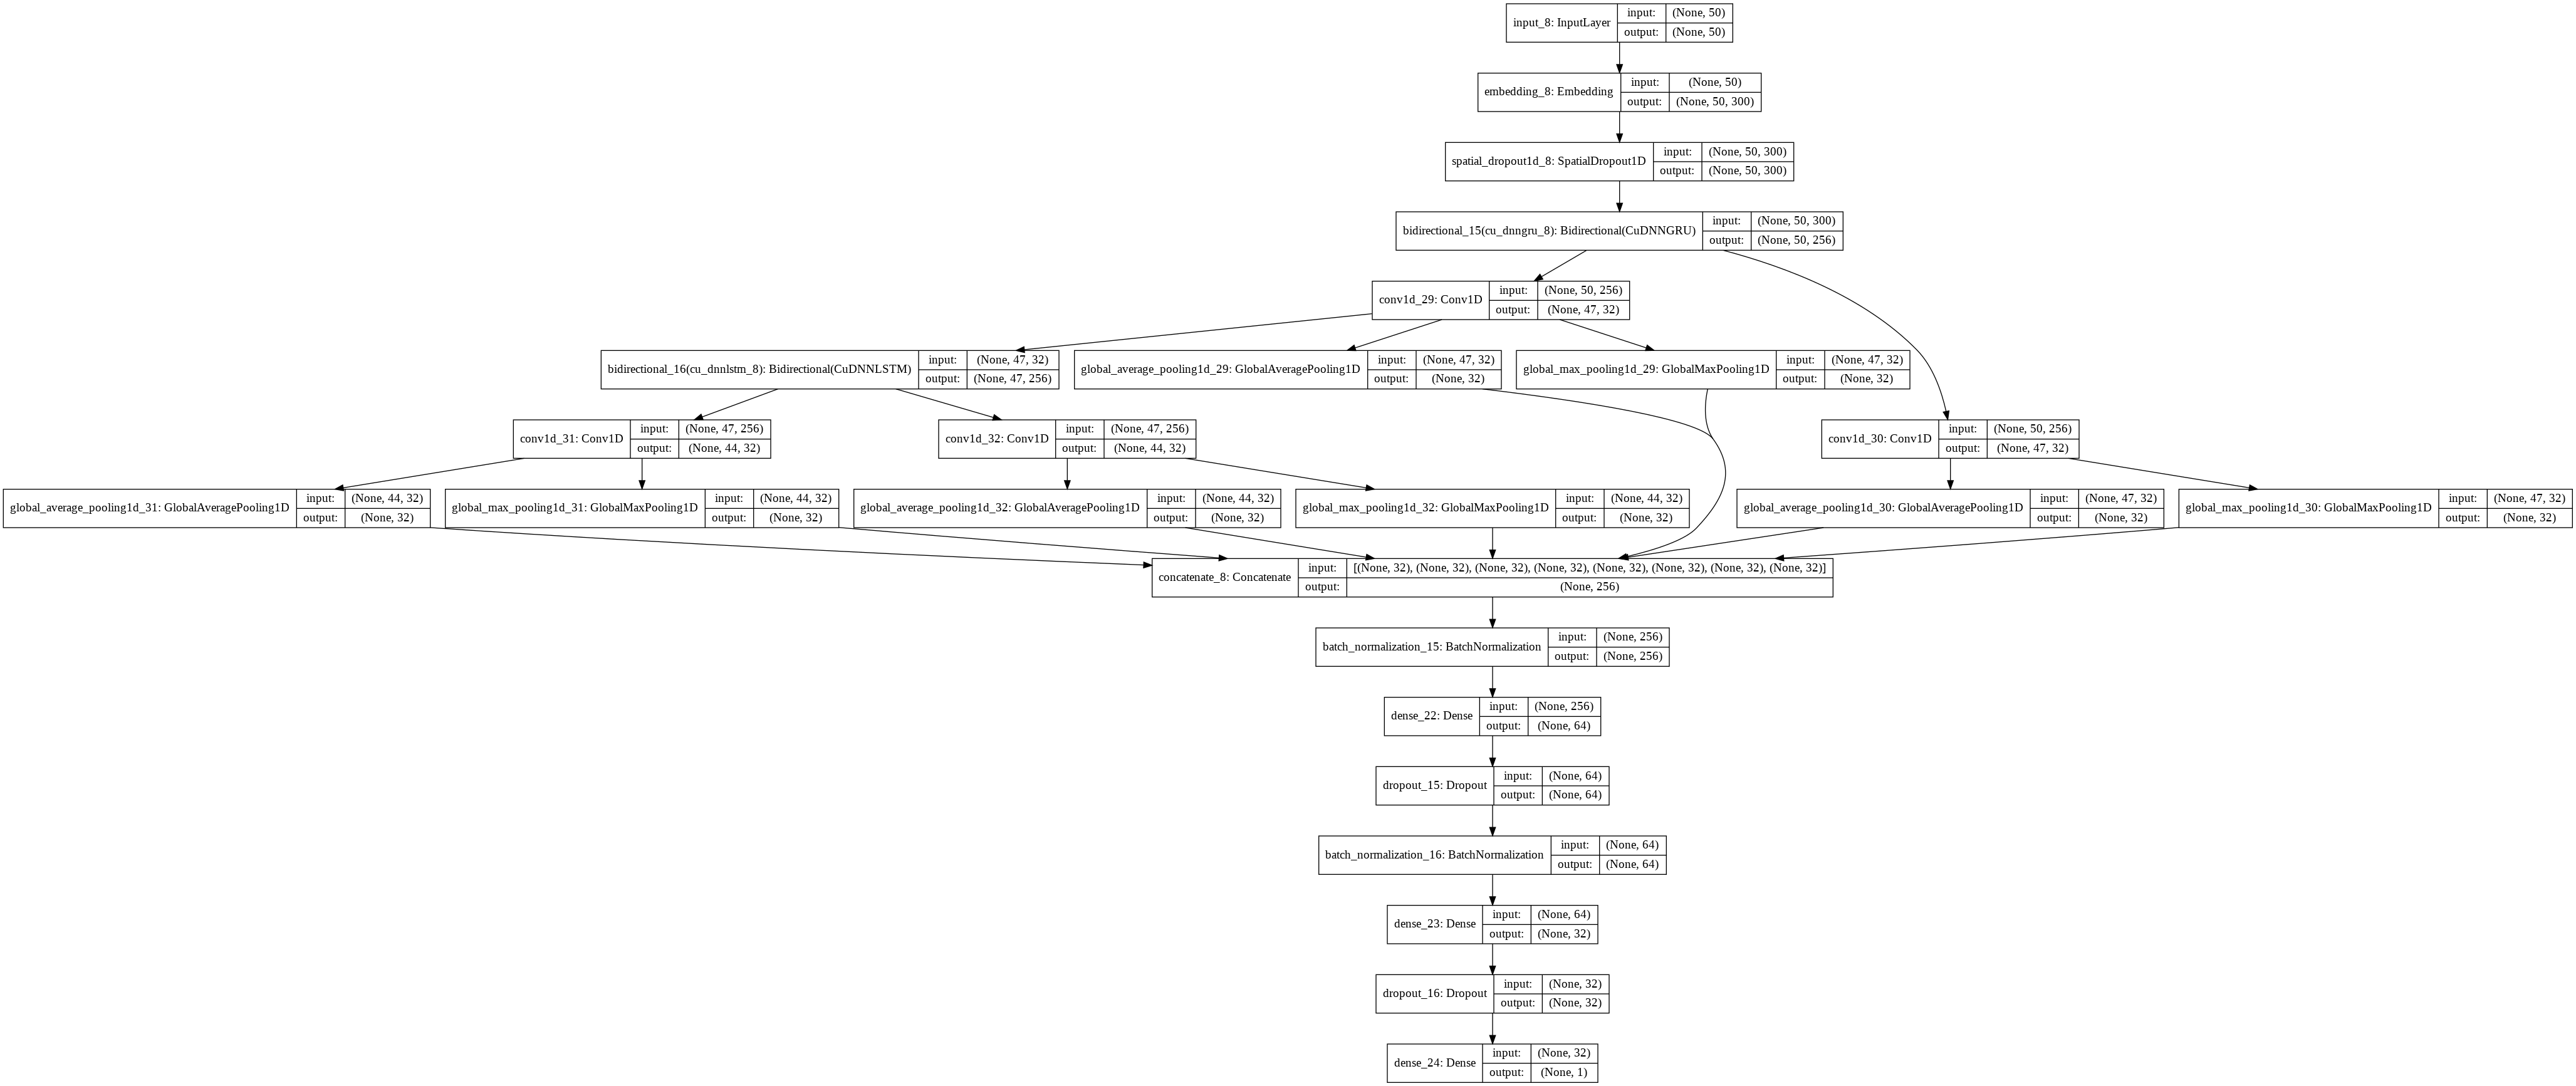

In [0]:
from keras.utils.vis_utils import plot_model
#hist_list = []
#for val in [32, 64, 128]:
model = build_model1(lr = 10e-3, lr_d = 1e-10, units = 128, spatial_dr = .4, kernel_size1=4, kernel_size2=4, dense_units=64, dr=.3, conv_size=32)
#hist_list.append(history)
plot_model(model, to_file='/content/drive/My Drive/F3/model_plot.png', show_shapes=True, show_layer_names=True)

In [0]:
print(prediction)
#np.savetxt("/content/drive/My Drive/F3/predictions.csv", prediction, delimiter=",")
print(evaluation)
#np.savetxt("/content/drive/My Drive/F3/evaluation.csv", evaluation, delimiter=",")
print(history.history['acc'])

In [0]:
import matplotlib.pyplot as plt

################################################################################
# Visualization and Output

image_dir = '/content/drive/My Drive/F3/'
#Loss curves
plt.figure(1)
plt.plot(range(len(history.history['loss'])), history.history['loss'], "r", label="Training Loss")
plt.plot(range(len(history.history['val_loss'])), history.history['val_loss'], "b", label="Validation Loss")
plt.title("Loss Curves" )
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.legend()
plt.savefig(image_dir + "final" + '_loss.png')
plt.show()

# Accuracy curves
plt.figure(2)
plt.plot(range(len(history.history['acc'])), history.history['acc'], "r", label="Training Accuracy")
plt.plot(range(len(history.history['val_acc'])), history.history['val_acc'], "b", label="Validation Accuracy")
plt.title("Accuracy Curves")
plt.xlabel("Number of Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig(image_dir + "final" + '_accuracy.png')
plt.show()

